## Assingment 4

Simple object detection model

student_name = "Leo Davidov"
student_email = "ae3240@student.jamk.fi"

## Dataset

The Dataset is photos of planes, birds, drones, and helicopters. Dataset have around 11000 images in total, 10000 for training, and around 600 in test and validation folders. Images are labeled and have corresponding bounding box for the object detection. Some of images miss labeling and bounding data, or have it corrupted. Dataset was found on Kaggle. https://www.kaggle.com/datasets/cybersimar08/drone-detection/data

## Data loading and preprocessing

I will load only 5000 images, due to limitations of my computer. Images are shuffled during loading, and images which have empty or corrupted labelling data will be skipped during loading. Frist by checking corresponding labeling data.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

#Getting labels first
MAX_PICS = 5000
labels = [] #array for labels 0-2
bboxes = [] #array for arrays of bboxes
labels_path = "dataset/train/labels/"
valid_pics = [] #array for the filenames of the images, which data was successefully loaded
filenames = os.listdir(labels_path)
random.shuffle(filenames)
i = 0
for label in filenames:
    file_path = os.path.join(labels_path, label)
    try:
        file = open(file_path, "r")
        data = file.read()
        if  len(data) > 0:
            data = data.strip().split()
            if len(data) == 5:
                valid_pics.append(label[:-4] + ".jpg")
                labels.append([int(data[0])]) #get label
                bboxes.append([float(x) for x in data[1:]]) #get bbox
                i+=1
    except Exception as ex:
        print(ex)
    finally:
        file.close()
    if i == MAX_PICS:
        break
print(len(labels))
print(len(bboxes))
print(len(labels))
labels = np.array(labels)
bboxes = np.array(bboxes)
print("Unique classes: ", np.unique(labels[:, 0]))

5000
5000
5000
Unique classes:  [0 1 2]


# Loading images

On loading of images i scaled them into 256x256 from 640x640 (not good for accurracy, but good for my computer). Data for bounding boxes was originally normalized so we don't need to adapt it separately after scaling.
Results are being visualized using matplotlib.

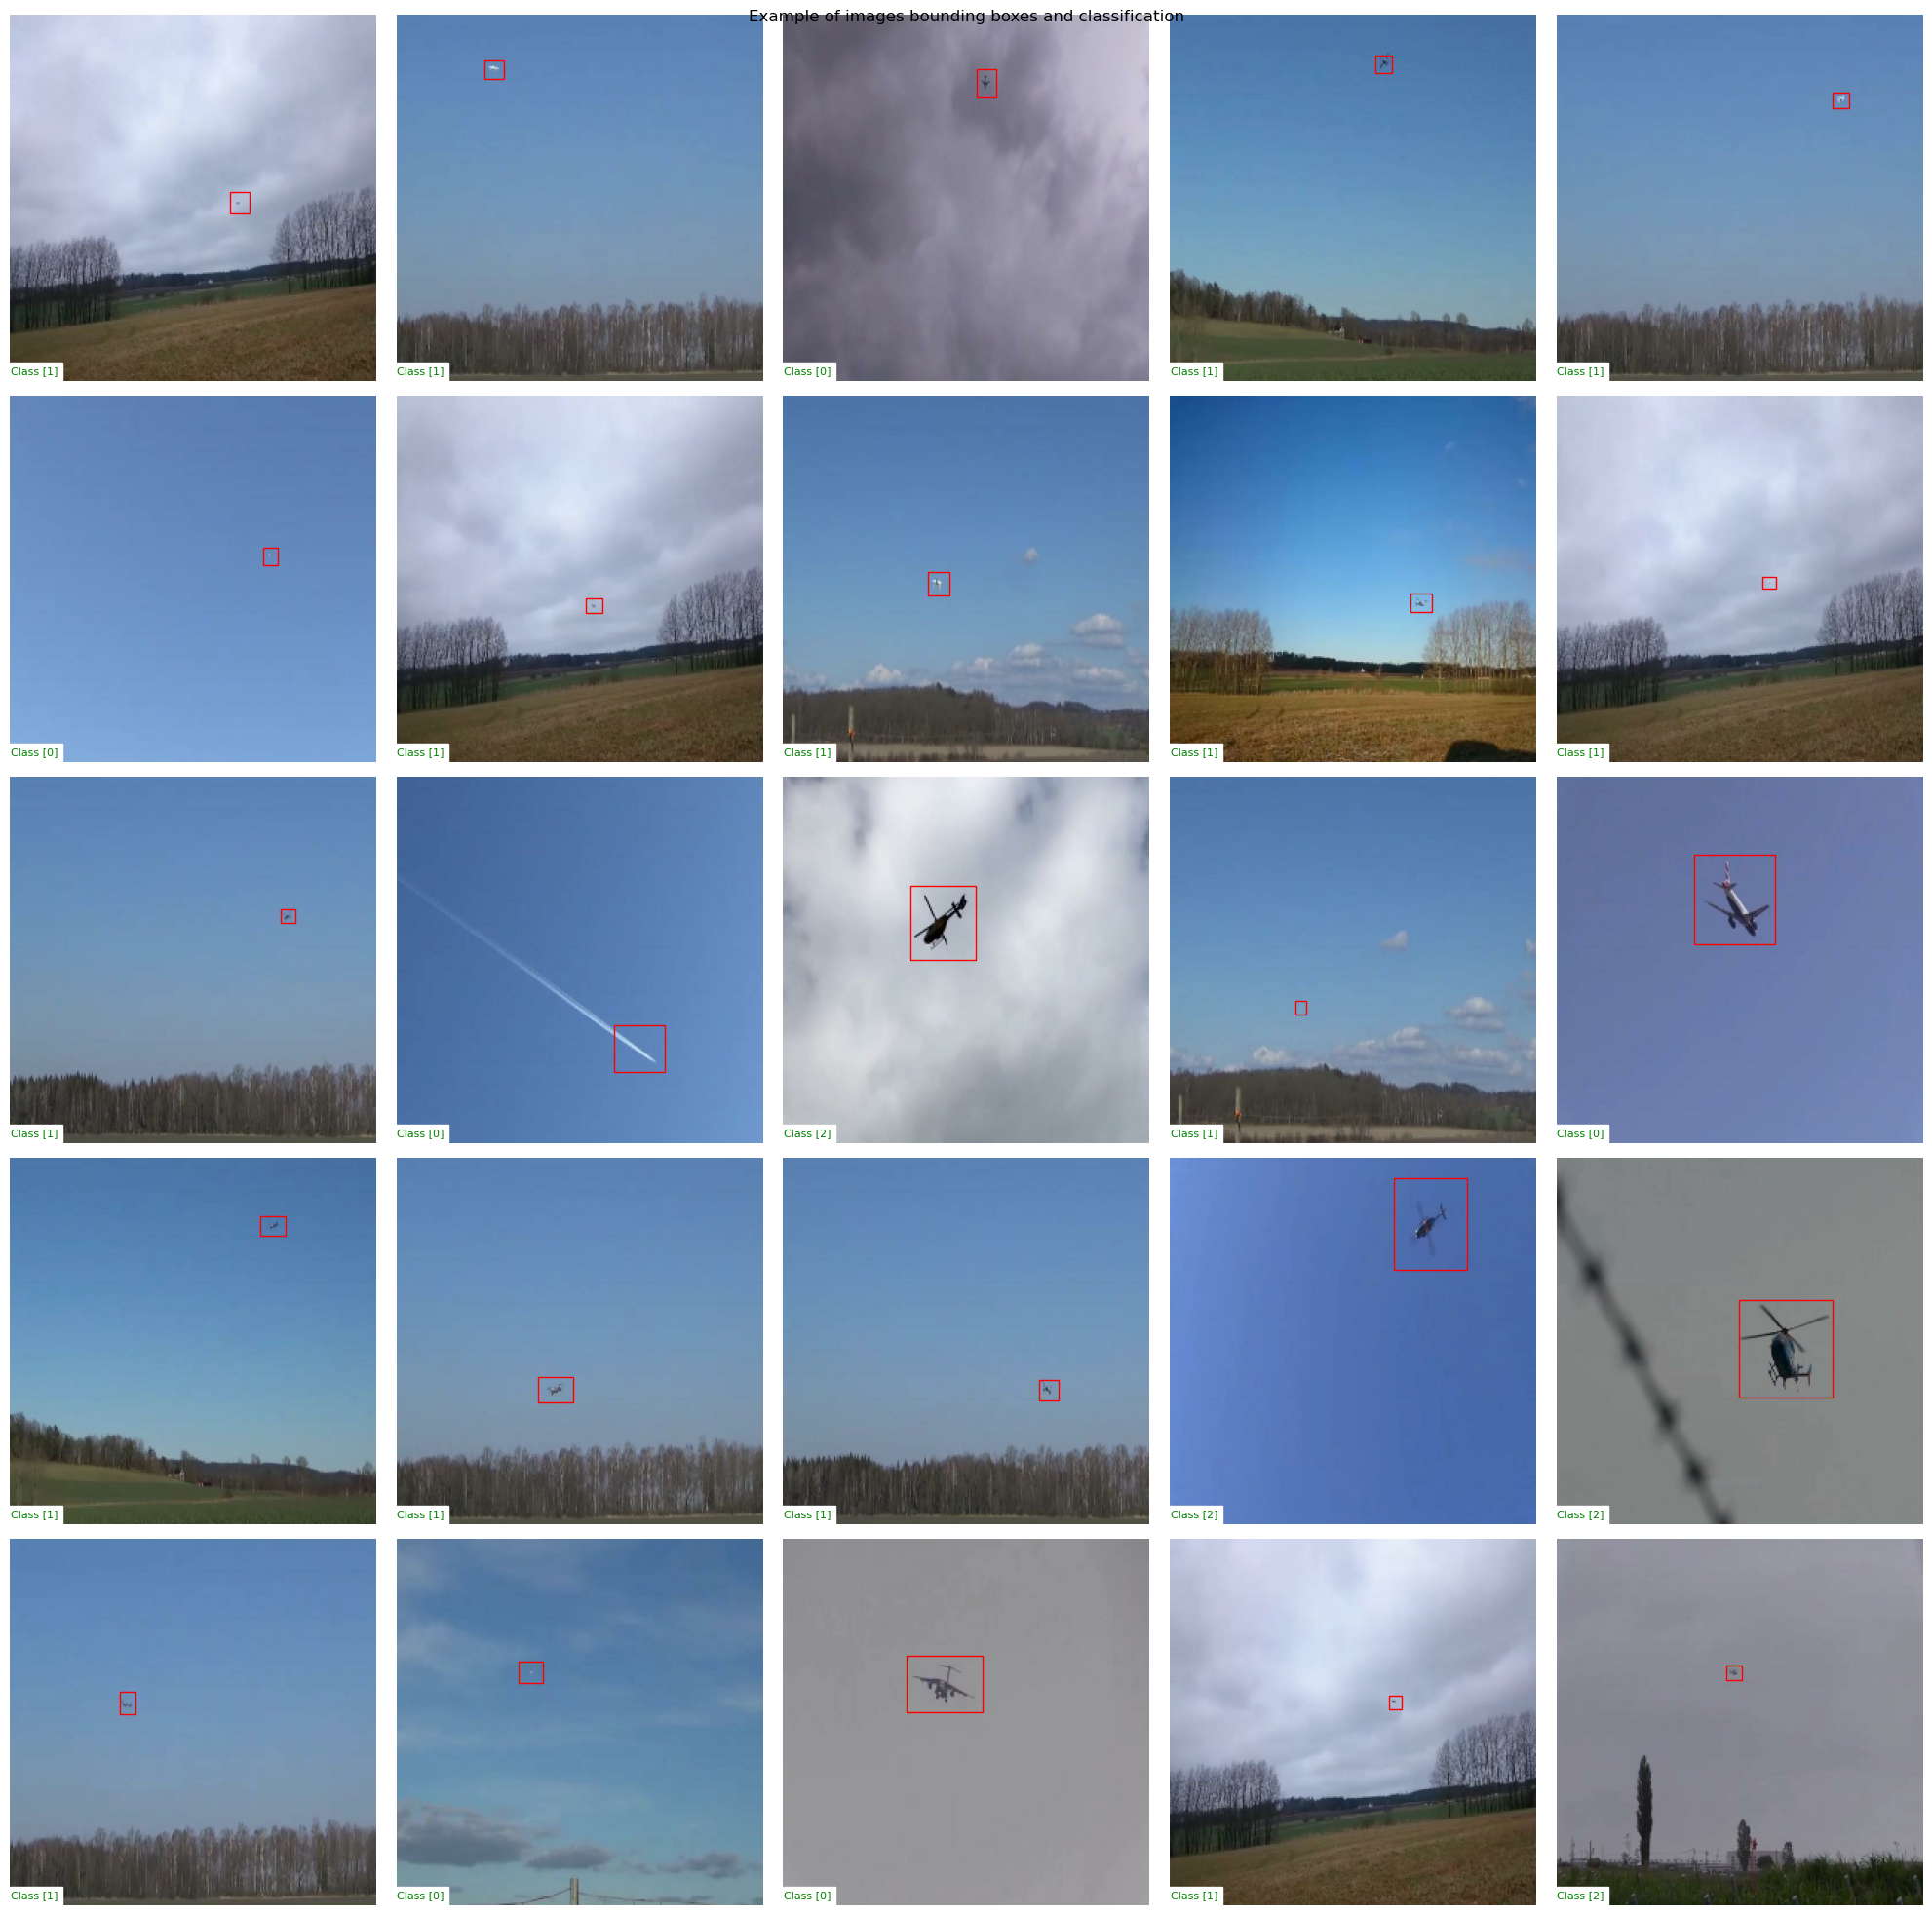

In [2]:

SCALE_X = 256
SCALE_Y = 256
images_path = "dataset/train/images/"
images = []

# Loop over the images in the folder
for picture in valid_pics:
    image = tf.io.read_file(images_path + picture)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (SCALE_X, SCALE_Y)) 
    image = tf.cast(image, dtype=tf.float32) / 255.0  #
    images.append(image.numpy())

images = np.array(images)

#Plotting the results

fig, axes = plt.subplots(5, 5, figsize=(20, 20)) 
for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        center_x, center_y, width, height = bboxes[idx]
        class_id = labels[idx]
        x_min = (center_x - width / 2) * SCALE_X
        y_min = (center_y - height / 2) * SCALE_Y
        x_max = (center_x + width / 2) * SCALE_X
        y_max = (center_y + height / 2) * SCALE_Y
        label_text = f"Class {class_id}"
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        axes[i, j].imshow(images[idx]) 
        axes[i, j].add_patch(rect)
        axes[i, j].text(0, SCALE_Y-5, label_text, color="green", backgroundcolor = "white", fontsize=8)
        axes[i, j].axis('off') 
plt.suptitle("Example of images bounding boxes and classification")        
plt.tight_layout()
plt.show()

    

# Building simple object detector - classifier

Typically object detection models consist of regressor and classifier, following a stack of convolutional and pooling layers. Classifier tries to predict classes, while regressor match the bounding box.

Unique classes:  [0 1 2]


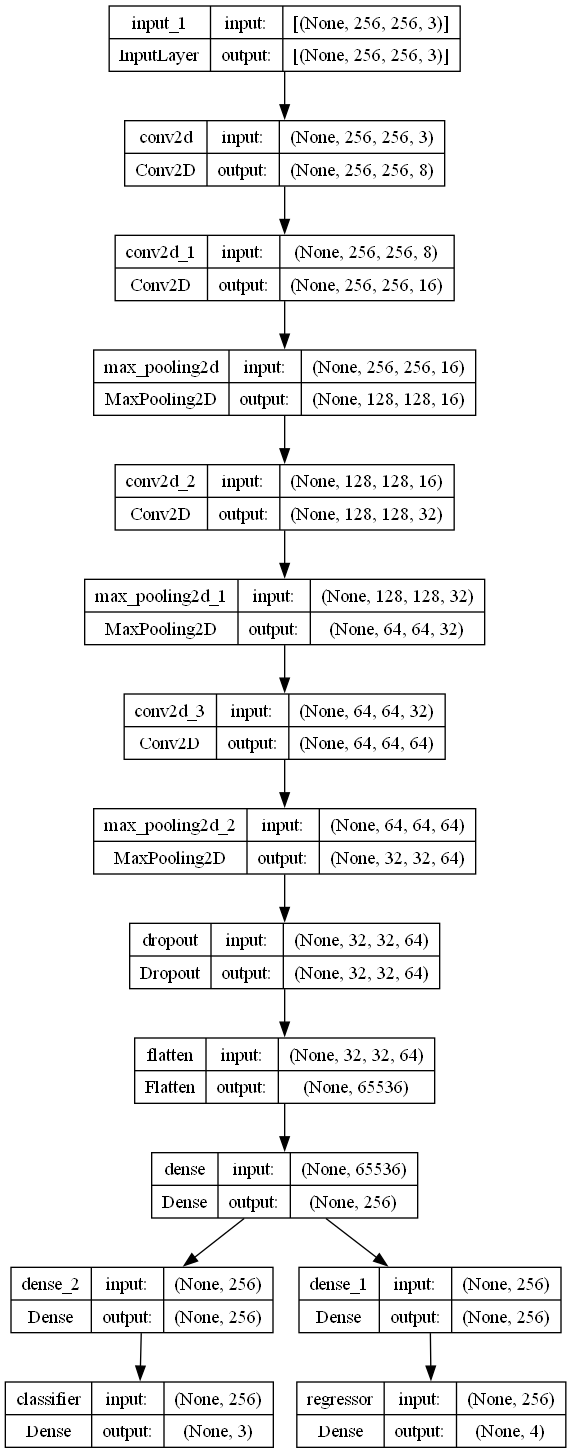

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  1168        ['conv2d[0][0]']                 
                                )                                                                 
                                                                                              

In [3]:
total_classes = len(np.unique(labels[:, 0]))
print("Unique classes: ", np.unique(labels[:, 0]))
# Object detection model

input = tf.keras.layers.Input((SCALE_X, SCALE_Y, 3))
conv = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', data_format="channels_last", strides=(1,1), padding="same")(input)
conv1 = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', strides=(1,1), padding="same")(conv)
Pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu', strides=(1,1), padding="same" )(Pool1)
Pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu', strides=(1,1), padding="same")(Pool2)
Pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3)
dropout = tf.keras.layers.Dropout(0.1)(Pool3)
flatten =  tf.keras.layers.Flatten()(dropout)
dense = tf.keras.layers.Dense(256, activation = 'relu')(flatten) #kernel_regularizer=tf.keras.regularizers.L2(0.1)
dense_reg = tf.keras.layers.Dense(256, activation= 'relu')(dense)
classifier_reg = tf.keras.layers.Dense(256, activation= 'relu')(dense)
classifer = tf.keras.layers.Dense(total_classes, activation="softmax", name = "classifier")(classifier_reg)
regressor = tf.keras.layers.Dense(4, name = "regressor")(dense_reg)
model = tf.keras.Model(inputs = input, outputs = [classifer, regressor])



display(tf.keras.utils.plot_model(model, show_shapes=True))
model.summary()


# Preparing the data

In [4]:
total_classes = len(np.unique(labels[:, 0]))
print("Unique classes: ", np.unique(labels[:, 0]))

from sklearn.model_selection import train_test_split
X_train, X_test, Y_labels_train, Y_labels_test, Y_bboxes_train, Y_bboxes_test= train_test_split(images, labels, bboxes, test_size=0.2, random_state=42, shuffle=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, {"classifier": Y_labels_train, "regressor": Y_bboxes_train}))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, {"classifier": Y_labels_test, "regressor": Y_bboxes_test}))

for image, labels in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Classifier Label:", labels["classifier"])
    print("Bounding Box:", labels["regressor"])

BATCH_SIZE = 4

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Unique classes:  [0 1 2]
Image shape: (256, 256, 3)
Classifier Label: tf.Tensor([1], shape=(1,), dtype=int32)
Bounding Box: tf.Tensor([0.734375   0.37421875 0.05546875 0.0671875 ], shape=(4,), dtype=float64)


# Training simple object detector

Here i used MSE error, which might have affected the regressor resuls, since values for bounding boxes are normalized. I added only extra weight to the regressor loss.

In [5]:
#Not working correctly
'''
def tfcalculateBbox(bbox):
    x_min = (bbox[..., 0] - bbox[..., 2] / 2) * SCALE_X
    y_min = (bbox[..., 1] - bbox[..., 3] / 2) * SCALE_Y
    x_max = (bbox[..., 0] + bbox[..., 2] / 2) * SCALE_X
    y_max = (bbox[..., 1] + bbox[..., 3] / 2) * SCALE_Y
    return x_min, y_min, x_max, y_max

def tfIoU(y_true, y_pred):
    pred_x_min, pred_y_min, pred_x_max, pred_y_max = tfcalculateBbox(y_pred)
    true_x_min, true_y_min, true_x_max, true_y_max = tfcalculateBbox(y_true)

    xA = tf.maximum(pred_x_min, true_x_min)
    yA = tf.maximum(pred_y_min, true_y_min)
    xB = tf.minimum(pred_x_max, true_x_max)
    yB = tf.minimum(pred_y_max, true_y_max)
    inter_area = tf.maximum(0.0, xB - xA) * tf.maximum(0.0, yB - yA)
    #individual bounding box areas
    pred_area = (pred_x_max - pred_x_min) * (pred_y_max - pred_y_min)
    true_area = (true_x_max - true_x_min) * (true_y_max - true_y_min)
    # Intersection over union
    union_area = pred_area + true_area - inter_area + 1e-9  # division by zero
    iou = inter_area / union_area

    return 1 - iou 

    #Combined loss
def mse_iou_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    iou = tfIoU(y_true, y_pred)
    return mse + 0.5 * iou
'''

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
    loss = {'classifier' : 'sparse_categorical_crossentropy', 'regressor' : "mse" }, 
    metrics = {'classifier' : 'accuracy', 'regressor' : "mse" }, loss_weights={'classifier': 1.0, 'regressor': 3.0})
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, verbose = 1)

Epoch 1/50
1000/1000 [==============================] - 30s 21ms/step - loss: 0.4670 - classifier_loss: 0.3770 - regressor_loss: 0.0300 - classifier_accuracy: 0.8280 - regressor_mse: 0.0300 - val_loss: 0.3062 - val_classifier_loss: 0.2615 - val_regressor_loss: 0.0149 - val_classifier_accuracy: 0.8680 - val_regressor_mse: 0.0149
Epoch 2/50
1000/1000 [==============================] - 19s 19ms/step - loss: 0.1992 - classifier_loss: 0.1605 - regressor_loss: 0.0129 - classifier_accuracy: 0.9305 - regressor_mse: 0.0129 - val_loss: 0.1670 - val_classifier_loss: 0.1342 - val_regressor_loss: 0.0110 - val_classifier_accuracy: 0.9430 - val_regressor_mse: 0.0110
Epoch 3/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1405 - classifier_loss: 0.1080 - regressor_loss: 0.0108 - classifier_accuracy: 0.9550 - regressor_mse: 0.0108 - val_loss: 0.1274 - val_classifier_loss: 0.0972 - val_regressor_loss: 0.0101 - val_classifier_accuracy: 0.9600 - val_regressor_mse: 0.0101
Epoch 4/50

# Plotting the results

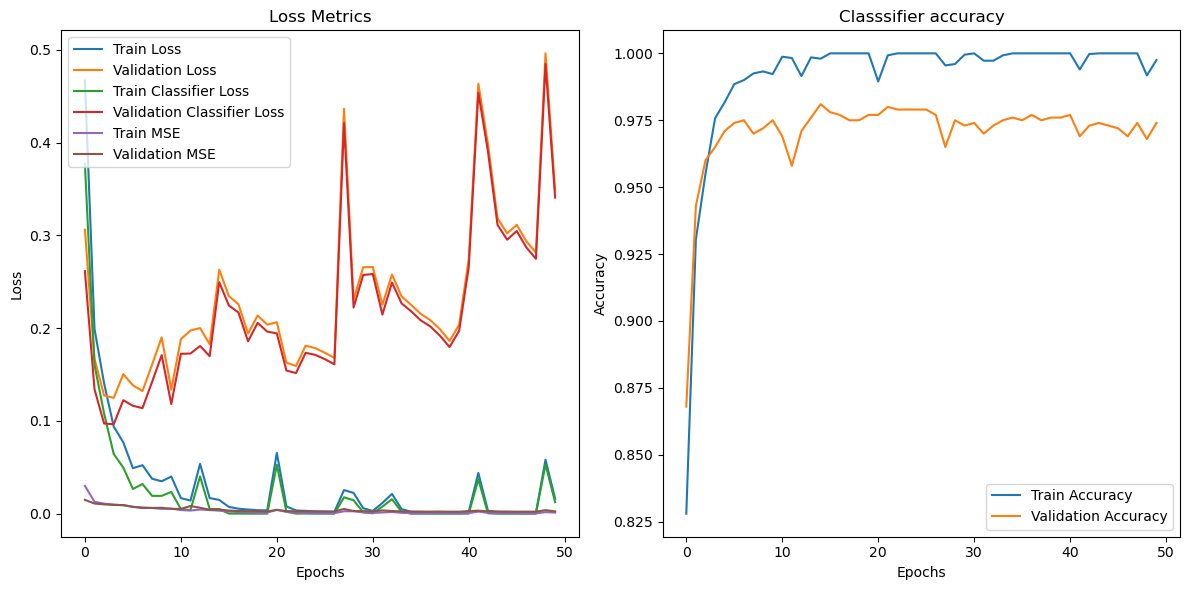

In [ ]:
def plothistory(history):
    train_loss = history.history['loss']
    train_classifier_loss = history.history['classifier_loss']
    train_regressor_loss = history.history['regressor_loss']
    train_classifier_accuracy = history.history['classifier_accuracy']

    val_loss = history.history['val_loss']
    val_classifier_loss = history.history['val_classifier_loss']
    val_regressor_loss = history.history['val_regressor_loss']
    val_classifier_accuracy = history.history['val_classifier_accuracy']

    plt.figure(figsize=(12, 6))
    #Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.plot(train_classifier_loss, label="Train Classifier Loss")
    plt.plot(val_classifier_loss, label="Validation Classifier Loss")
    plt.plot(train_regressor_loss, label="Train MSE")
    plt.plot(val_regressor_loss, label="Validation MSE")
    plt.title("Loss Metrics")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_classifier_accuracy, label="Train Accuracy")
    plt.plot(val_classifier_accuracy, label="Validation Accuracy")
    plt.title("Classsifier accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plothistory(history)

250/250 [==============================] - 1s 5ms/step
Average intersection over union:  0.2906435343315791
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       247
           1       1.00      1.00      1.00       495
           2       0.95      0.95      0.95       258

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



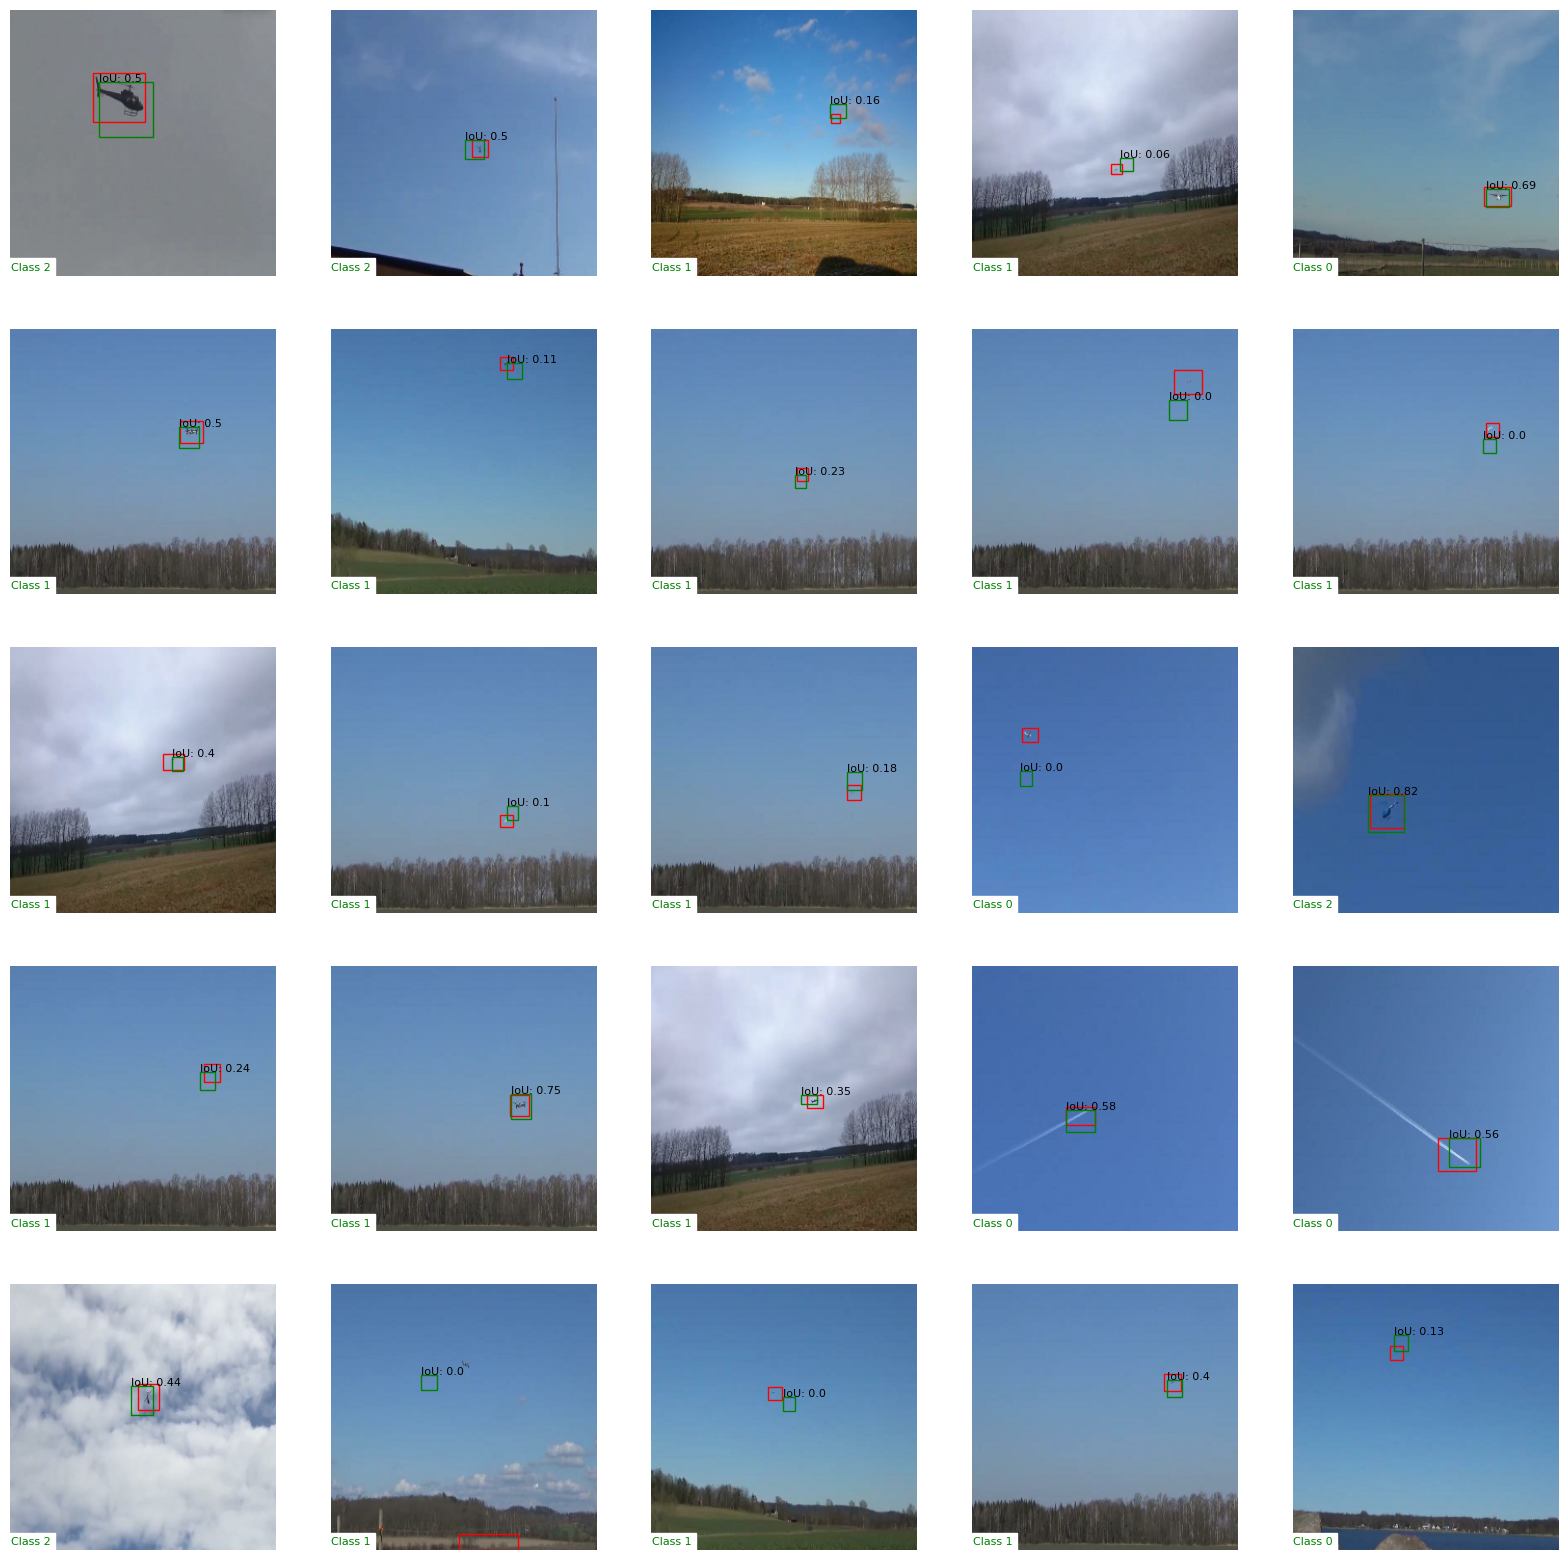

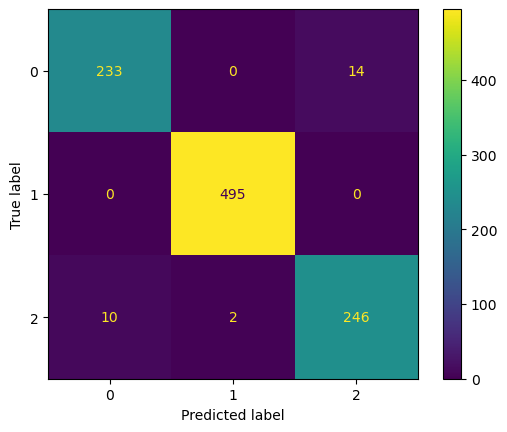

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def calculateBbox(bbox):
    x_min = (bbox[0] - bbox[2] / 2) * SCALE_X
    y_min = (bbox[1] - bbox[3] / 2) * SCALE_Y
    x_max = (bbox[0] + bbox[2] / 2) * SCALE_X
    y_max = (bbox[1] + bbox[3] / 2) * SCALE_Y
    return [x_min, y_min, x_max, y_max]

def IoU(pred_box, true_box):
    pred_x_min, pred_y_min, pred_x_max, pred_y_max = calculateBbox(pred_box)
    true_x_min, true_y_min, true_x_max, true_y_max = calculateBbox(true_box)
    xA = max(pred_x_min, true_x_min)
    yA = max(pred_y_min, true_y_min)
    xB = min(pred_x_max, true_x_max)
    yB = min(pred_y_max, true_y_max)
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    pred_area = (pred_x_max - pred_x_min) * (pred_y_max - pred_y_min)
    true_area = (true_x_max - true_x_min) * (true_y_max - true_y_min)
    iou = inter_area / float(pred_area + true_area - inter_area + 1e-9)  # division by zero
    return iou


predictions = model.predict(test_dataset)
class_preds = np.argmax(predictions[0], axis=1)
bboxes_preds = predictions[1]

#X_test are our test images
def plotResults(class_preds, bboxes_preds):
    fig, axes = plt.subplots(5, 5, figsize=(20, 20)) 
    for i in range(5):
        for j in range(5):
            idx = i * 5 + j
            class_id = class_preds[idx]
            x_min, y_min, x_max, y_max = calculateBbox(Y_bboxes_test[idx])
            label = f"Class {class_id}"
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            axes[i, j].add_patch(rect)
            x_min, y_min, x_max, y_max = calculateBbox(bboxes_preds[idx])
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='g', facecolor='none')
            axes[i, j].text(x_min, y_min, f"IoU: {round(IoU(bboxes_preds[idx], Y_bboxes_test[idx]),2)}", color="black", backgroundcolor = "none", fontsize=8)
            axes[i, j].add_patch(rect)
            axes[i, j].imshow(X_test[idx]) 
            axes[i, j].text(0, SCALE_Y-5, label, color="green", backgroundcolor = "white", fontsize=8)
            axes[i, j].axis('off')
    cr = classification_report(Y_labels_test.ravel(), class_preds)
    cm = confusion_matrix(Y_labels_test.ravel(), class_preds)
    averageIoU = np.array([])
    for bbox_pred, bbox_true in zip(bboxes_preds,Y_bboxes_test):
        averageIoU = np.append(averageIoU, (IoU(bbox_pred, bbox_true)))
    averageIoU = np.mean(np.array(averageIoU))
    print("Average intersection over union: ", averageIoU)
    print(cr)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()

plotResults(class_preds, bboxes_preds)

# Model using ResNet sctructure

In [8]:
input_Model = tf.keras.applications.ResNet50(include_top=False, input_shape=(SCALE_X, SCALE_Y, 3))
for layer in input_Model.layers:
    layer.trainable = True
input = tf.keras.layers.Input(shape=(SCALE_X, SCALE_Y, 3))
resnet = input_Model(input)
globalPool = tf.keras.layers.GlobalAveragePooling2D()(resnet)
class_output = tf.keras.layers.Dense(total_classes, activation='softmax', name="classifier")(globalPool)
bbox_output = tf.keras.layers.Dense(4, activation='sigmoid', name="regressor")(globalPool)
transfer_model = tf.keras.models.Model(inputs=input, outputs=[class_output, bbox_output])

transfer_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 8, 8, 2048)   23587712    ['input_3[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                            

# Training

Regressor is set to mean absolute error here (produces bigger error in comparison to mse, since we don't calculate square of number which is less than 1), also a good choice can be mean absolute percentage error. Mse might be not so good since difference between values might be very small due to normalization of bounding box coordinates (between 0 and 1). Also can be used Huber loss which is a combination of MSE and MAE, less sensitive to outliers. It is used in Faster R-CNN and YOLO for better bounding box regression.

In [9]:

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss= {'classifier' : tf.losses.sparse_categorical_crossentropy, 'regressor' : tf.losses.mean_absolute_error }, 
    metrics = {'classifier' : 'accuracy', 'regressor' : tf.losses.mean_absolute_error })
history = transfer_model.fit(train_dataset, validation_data=test_dataset, epochs=20, verbose = 1)

Epoch 1/20
1000/1000 [==============================] - 99s 91ms/step - loss: 0.2210 - classifier_loss: 0.1443 - regressor_loss: 0.0767 - classifier_accuracy: 0.9515 - regressor_mean_absolute_error: 0.0767 - val_loss: 0.3049 - val_classifier_loss: 0.2235 - val_regressor_loss: 0.0814 - val_classifier_accuracy: 0.9170 - val_regressor_mean_absolute_error: 0.0814
Epoch 2/20
1000/1000 [==============================] - 91s 91ms/step - loss: 0.0938 - classifier_loss: 0.0385 - regressor_loss: 0.0553 - classifier_accuracy: 0.9862 - regressor_mean_absolute_error: 0.0553 - val_loss: 0.0847 - val_classifier_loss: 0.0155 - val_regressor_loss: 0.0692 - val_classifier_accuracy: 0.9930 - val_regressor_mean_absolute_error: 0.0692
Epoch 3/20
1000/1000 [==============================] - 96s 96ms/step - loss: 0.0851 - classifier_loss: 0.0372 - regressor_loss: 0.0479 - classifier_accuracy: 0.9875 - regressor_mean_absolute_error: 0.0479 - val_loss: 0.0530 - val_classifier_loss: 0.0016 - val_regressor_loss:

# ResNet Metrics

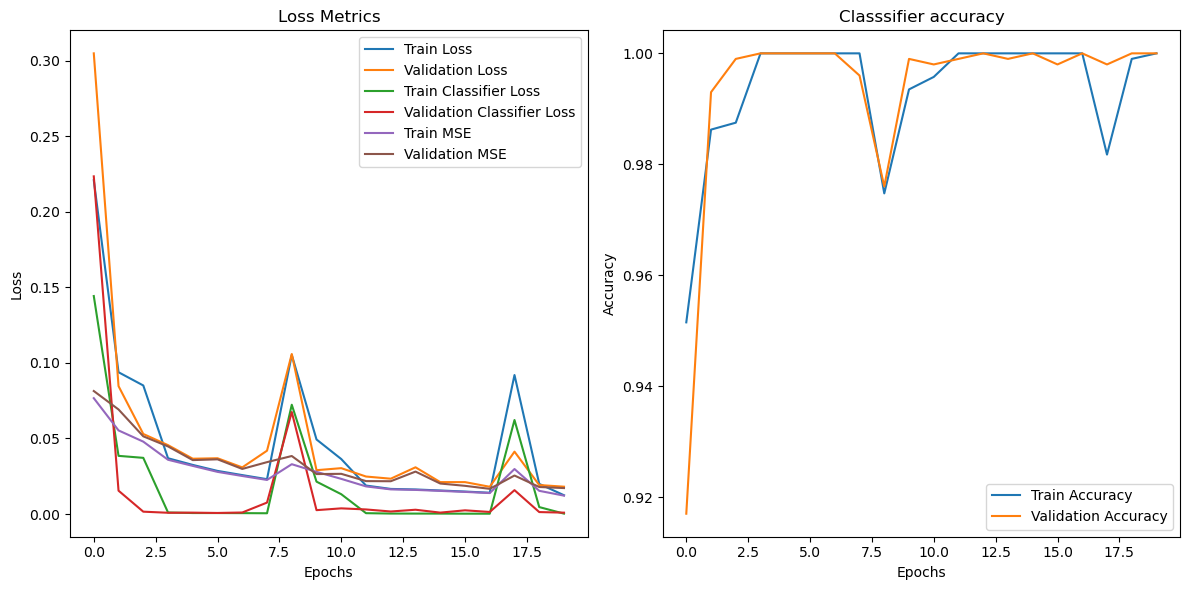

In [10]:
plothistory(history)

# ResNet Results

250/250 [==============================] - 7s 22ms/step
Average intersection over union:  0.3949064098008102
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       1.00      1.00      1.00       495
           2       1.00      1.00      1.00       258

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



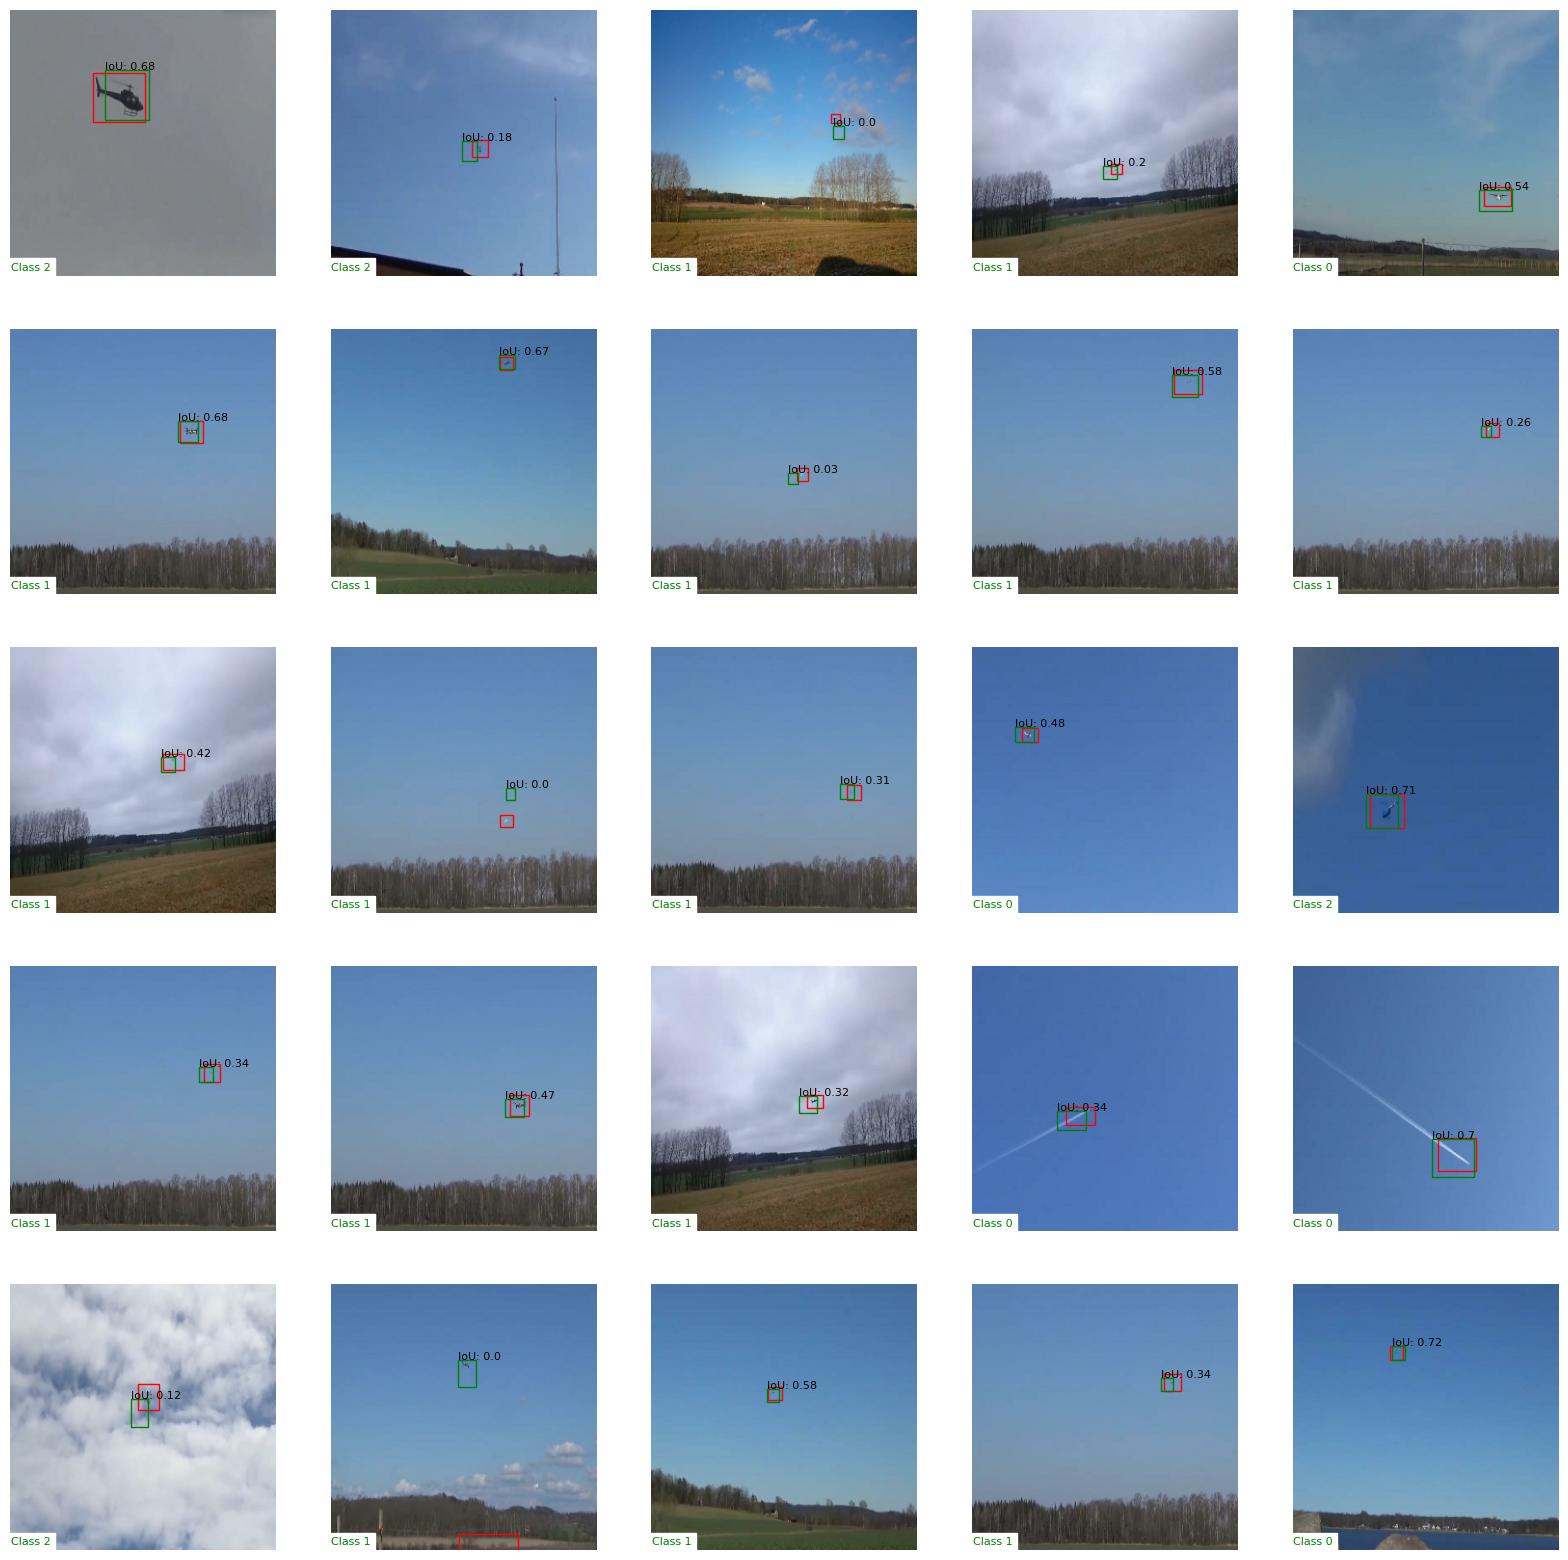

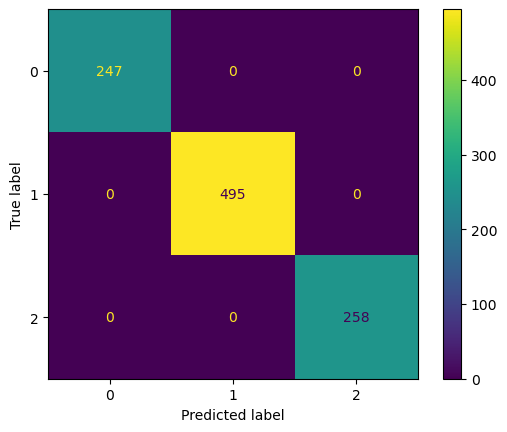

In [11]:
predictions = transfer_model.predict(test_dataset)
class_preds = np.argmax(predictions[0], axis=1)
bboxes_preds = predictions[1]
plotResults(class_preds, bboxes_preds)

# Model with separate convolutional layers for classifier and regressor

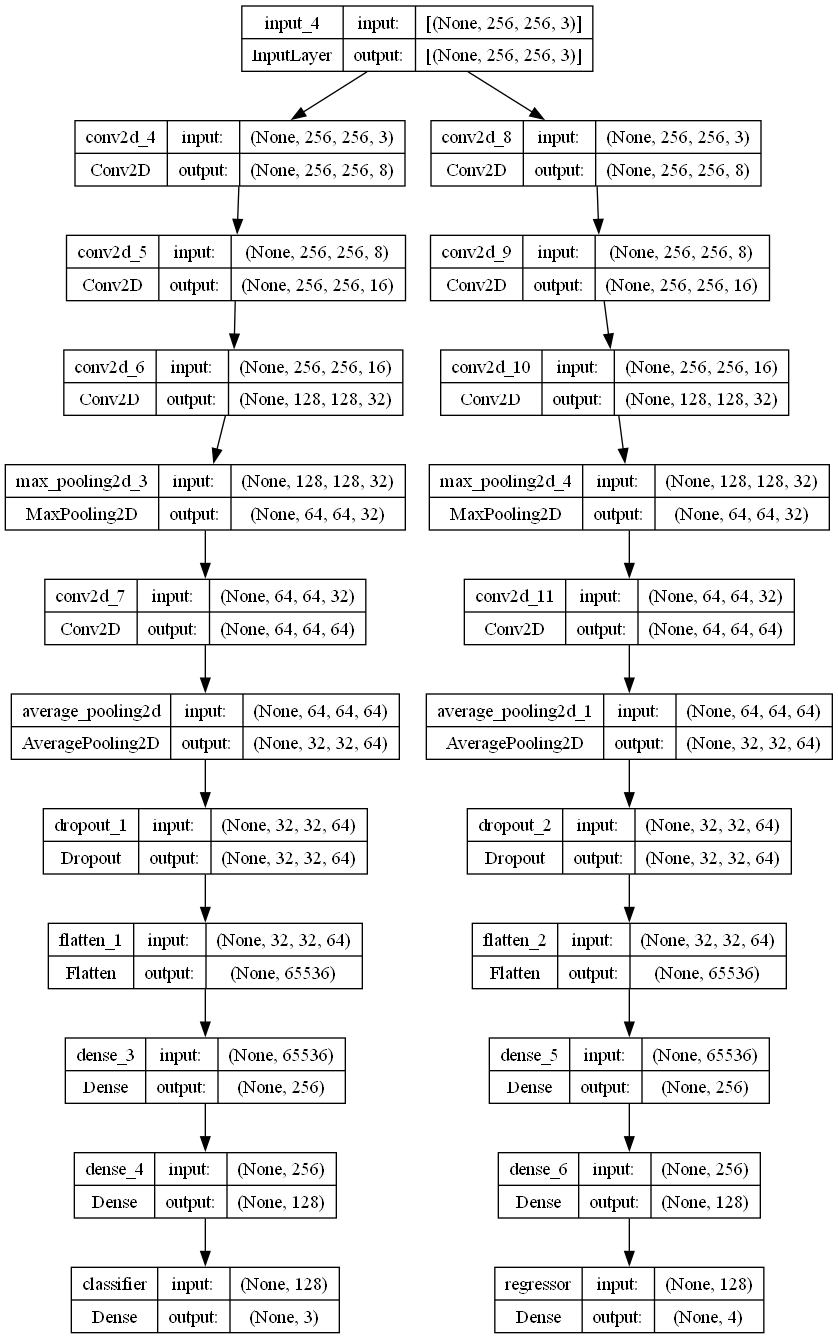

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 8)  224         ['input_4[0][0]']                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 256, 256, 8)  224         ['input_4[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 256, 256, 16  1168        ['conv2d_4[0][0]']         

In [12]:
input = tf.keras.layers.Input((SCALE_X, SCALE_Y, 3))

def buildClassifer(input):
    conv = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', data_format="channels_last", strides=(1,1), padding="same")(input)
    conv1 = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', strides=(1,1), padding="same")(conv)
    conv2 = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu', strides=(2,2), padding="same" )(conv1)
    Pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu', strides=(1,1), padding="same")(Pool2)
    Pool3 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv3)
    dropout = tf.keras.layers.Dropout(0.1)(Pool3)
    flatten =  tf.keras.layers.Flatten()(dropout)
    dense = tf.keras.layers.Dense(256, activation = 'relu')(flatten) #kernel_regularizer=tf.keras.regularizers.L2(0.1)
    classifier_reg = tf.keras.layers.Dense(128, activation= 'relu')(dense)
    classifer = tf.keras.layers.Dense(total_classes, activation="softmax", name = "classifier")(classifier_reg)
    return classifer

def buildRegressor(input):
    conv = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu', data_format="channels_last", strides=(1,1), padding="same")(input)
    conv1 = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', strides=(1,1), padding="same")(conv)
    conv2 = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu', strides=(2,2), padding="same" )(conv1)
    Pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
    conv3 = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu', strides=(1,1), padding="same")(Pool2)
    Pool3 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv3)
    dropout = tf.keras.layers.Dropout(0.1)(Pool3)
    flatten =  tf.keras.layers.Flatten()(dropout)
    dense = tf.keras.layers.Dense(256, activation = 'relu')(flatten) #kernel_regularizer=tf.keras.regularizers.L2(0.1)
    dense_reg = tf.keras.layers.Dense(128, activation= 'relu')(dense)
    regressor = tf.keras.layers.Dense(4, name = "regressor")(dense_reg)
    return regressor

classifer = buildClassifer(input)
regressor = buildRegressor(input)

model = tf.keras.Model(inputs = input, outputs = [classifer, regressor])
display(tf.keras.utils.plot_model(model, show_shapes=True))
model.summary()

# Training

Regressor is set to mean absolute error here, also a good choice can be mean absolute percentage error. Mse might be not so good since difference between values might be very small due to normalization of bounding box coordinates (between 0 and 1). Also can be used Huber loss which is a combination of MSE and MAE

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
    loss = {'classifier' : 'sparse_categorical_crossentropy', 'regressor' : "mae" }, 
    metrics = {'classifier' : 'accuracy', 'regressor' : "mae" }, loss_weights={'classifier': 1.0, 'regressor': 3.0})
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, verbose = 1)

Epoch 1/50
1000/1000 [==============================] - 32s 31ms/step - loss: 0.6086 - classifier_loss: 0.3632 - regressor_loss: 0.0818 - classifier_accuracy: 0.8290 - regressor_mae: 0.0818 - val_loss: 0.5979 - val_classifier_loss: 0.4084 - val_regressor_loss: 0.0632 - val_classifier_accuracy: 0.8350 - val_regressor_mae: 0.0632
Epoch 2/50
1000/1000 [==============================] - 31s 31ms/step - loss: 0.4009 - classifier_loss: 0.2225 - regressor_loss: 0.0595 - classifier_accuracy: 0.9038 - regressor_mae: 0.0595 - val_loss: 0.5037 - val_classifier_loss: 0.3301 - val_regressor_loss: 0.0579 - val_classifier_accuracy: 0.8550 - val_regressor_mae: 0.0579
Epoch 3/50
1000/1000 [==============================] - 31s 31ms/step - loss: 0.3324 - classifier_loss: 0.1724 - regressor_loss: 0.0533 - classifier_accuracy: 0.9325 - regressor_mae: 0.0533 - val_loss: 0.3402 - val_classifier_loss: 0.1831 - val_regressor_loss: 0.0524 - val_classifier_accuracy: 0.9110 - val_regressor_mae: 0.0524
Epoch 4/50

# Veryfing the results

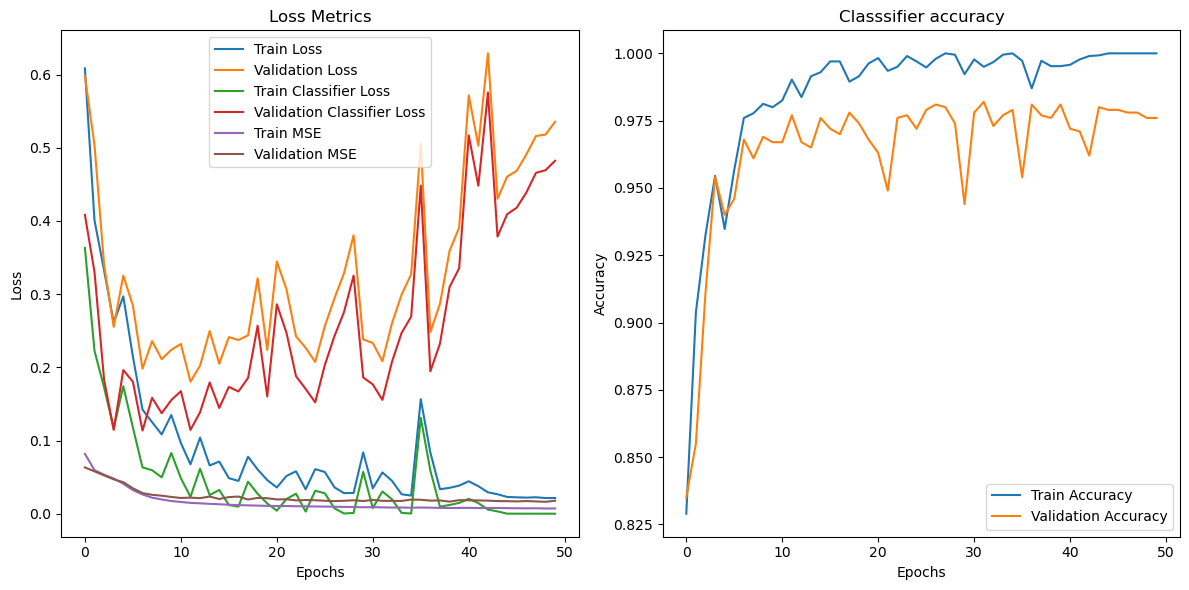

250/250 [==============================] - 2s 7ms/step
Average intersection over union:  0.4753403872648838
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       247
           1       1.00      1.00      1.00       495
           2       0.96      0.95      0.95       258

    accuracy                           0.98      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000



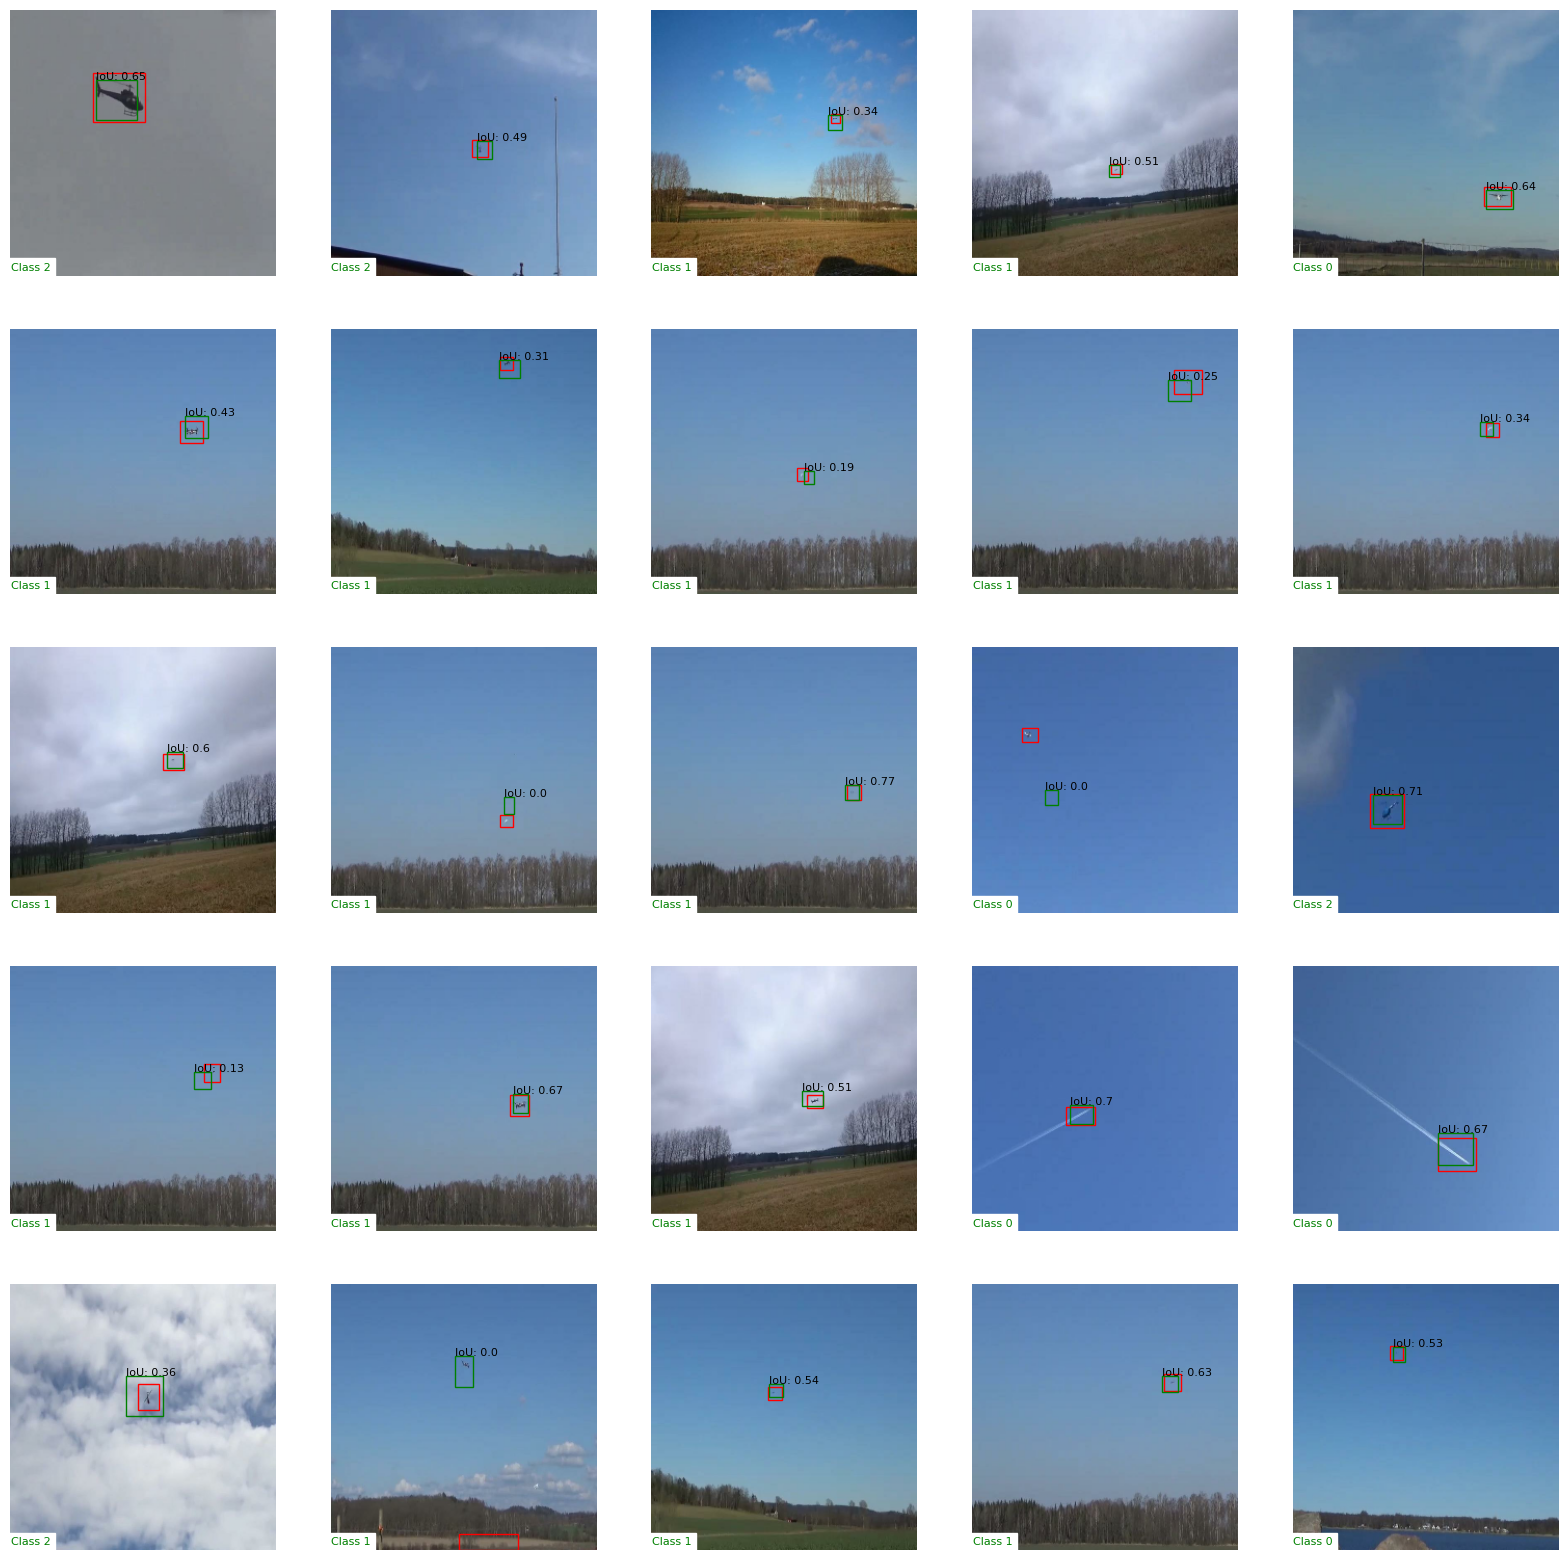

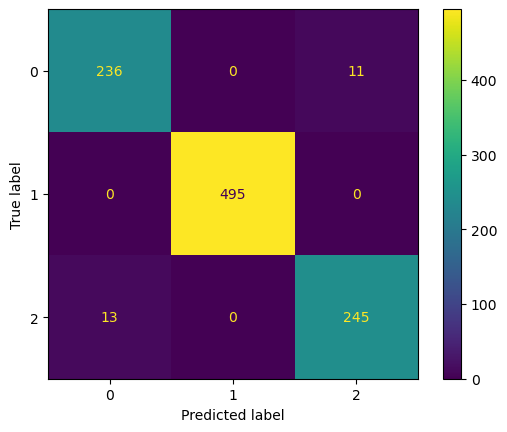

In [14]:
plothistory(history)

predictions = model.predict(test_dataset)
class_preds = np.argmax(predictions[0], axis=1)
bboxes_preds = predictions[1]

plotResults(class_preds, bboxes_preds)

# Reflection

This is a very simple implementation of machine vision. Data already had scaled bounding boxes which simplified implemention, and this dataset has only one object per picture. For better understanding of the idea I wanted to restrict my tool set only on tensorflow, numpy, matplotlib and sklearn. Of course for better results it is possible to use cv2, tensorflow object detection libraries and models such as YOLO, SSD, R-CNN

Metric "IoU" intersection over union is one of the most important metrics in object detection performance, it shows how good model is able to predict a bounding box relative to target bounding box. First model has average IoU of 0.29, second model which is a ResNet with classifer and regressor heads had this metric equal to 0.39 and third model which had two separate branches for convolutional layers had IoU equal to 0.47. From visualisation it is seen that models are definitely able to see and detect a bounding box for the flying objects in a pictures, of course if object is a tiny dot it may struggle, but it works. Classifier accuracy in all cases was nearly 100%, and first and third models are definitely overfitting classifer in a long run, but mostly classifier accuracy is 97-100% for all models. I suppose that model based on resnet could achieve top IoU if i would ran training for more epochs, first and third models are overfitting the classifier in a long run but imporve the regressor. So it is reasoble to add a regualizer, extra dropout layers at least for the classifer heads, and some batch/layer normalizations for the models. Also i suppose that it was a mistake to use mse for regressor in a first model, i future i would rather use huber loss or mape. Also image augmentation could improve the results, for instance by randomly rotating images.

In order to get better object detection results, it is necessary to use grid-based output approach and define a custom loss function. When the regressor and classifier are actually convolutional layers which output the grid space (for instance 16x16 with 3 filters wich correspond to the one hot-encoded labelling or 16x16 with 4 filters wich correspond to the bounding box position) it can give more precise localization of objects and also it is possible to detect multiple objects same time, such method can significantly improve IoU metric, but it will require additional preprocessing and data preparation. In classical implementation, it is neccessary to generate anchor boxes using scale factors and aspect ratios, then to map true bounding box to the suitable anchor box in a grid using for instance IoU, then encode true bounding box based on the offsets, then it is necessary to create grids from the labels and encoded bounding boxes based on decided feature space and amount of anchors per grid cell. 

I have tried to implement model in yolo style, but without anchor boxes which produces a grid with class probabilities, bbox coordinates and objectness flags, but it need to be debugged, not working properly at this point. But anyway, using a single regressor to predict the bounding box directly (without anchor boxes), will anyway make model to struggle to cover all possible range of shapes and sizes of bounding boxes. The regression would be trying to directly output all four parameters for the bounding box, which becomes very challenging for the model as it seen from the implementation in the code above. Anchor boxes can solve this problem by providing a set of predefined anchor shapes that the model can adjust during training.

![image](image.png)

I have also unfinished LLM project without documentation here: [LLM](Project.ipynb)

In [ ]:
#Model and preprocessing for grid based output in yolo style with objectness, currently not working properly, needs to be fixed, needs extra class label for background
'''
def create_Y_grid(data, grid_size=16, num_classes=total_classes):
    labels = []
    for label, box in data:
        labels = np.zeros((grid_size, grid_size, num_classes + 5)) 
        class_id = label
        x_center, y_center, width, height = box
        #  cell coordinates
        grid_x = int(x_center * grid_size)
        grid_y = int(y_center * grid_size)
        #  сhehking bounds
        grid_x = min(grid_x, grid_size - 1)
        grid_y = min(grid_y, grid_size - 1)
        # one-hot for class
        labels[grid_y, grid_x, class_id] = 1 
        #box
        labels[grid_y, grid_x, num_classes] = x_center  
        labels[grid_y, grid_x, num_classes+ 1] = y_center  
        labels[grid_y, grid_x, num_classes +2] = width  
        labels[grid_y, grid_x, num_classes+ 3] = height  
        # Object presence flag
        labels[grid_y, grid_x, num_classes+4] = 1
        labels.append(labels)

    return np.array(labels)

def custom_loss(y_true, y_pred):
    true_class, true_bbox, true_objectness = y_true[..., :total_classes], y_true[..., total_classes:-1], y_true[..., -1]
    pred_class, pred_bbox, pred_objectness = y_pred[..., :total_classes], y_pred[..., total_classes:-1], y_pred[..., -1]
    mask = tf.cast(true_objectness, tf.float32)
    class_loss = tf.reduce_sum(mask * tf.keras.losses.categorical_crossentropy(true_class, pred_class)) / tf.reduce_sum(mask)
    bbox_loss = tf.reduce_sum(mask * tf.keras.losses.mean_squared_error(true_bbox, pred_bbox)) / tf.reduce_sum(mask)
    objectness_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(true_objectness, pred_objectness))
    total_loss = class_loss + 6.0 * bbox_loss + objectness_loss
    return total_loss


Yolo_labels_train = create_Y_grid(zip(Y_labels_train,Y_bboxes_train))
Yolo_labels_test = create_Y_grid(zip(Y_labels_test,Y_bboxes_test))
print(Yolo_labels_train.shape)

BATCH_SIZE = 1
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Yolo_labels_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Yolo_labels_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#model
input = tf.keras.layers.Input((256, 256, 3))
conv = tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding="same", use_bias=False)(input)
norm = tf.keras.layers.LayerNormalization()(conv)
relu = tf.keras.layers.LeakyReLU(alpha=0.001)(norm)
conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same", use_bias=False)(relu)
norm1 = tf.keras.layers.LayerNormalization()(conv1)
relu1 = tf.keras.layers.LeakyReLU(alpha=0.001)(norm1)
conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same", use_bias=False)(relu1)
norm2 = tf.keras.layers.LayerNormalization()(conv2)
relu2 = tf.keras.layers.LeakyReLU(alpha=0.001)(norm2)
conv3 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same", use_bias=False)(relu2)
norm3 = tf.keras.layers.LayerNormalization()(conv3)
relu3 = tf.keras.layers.LeakyReLU(alpha=0.001)(norm3)
conv4 = tf.keras.layers.Conv2D(512, kernel_size=3, strides=2, padding="same", use_bias=False)(relu3)
norm4 = tf.keras.layers.LayerNormalization()(conv4)
relu4 = tf.keras.layers.LeakyReLU(alpha=0.001)(norm4)

classifier = tf.keras.layers.Conv2D(total_classes, (1,1), activation="softmax", name="classifier")(relu4)  # class probs per grid cell
regressor = tf.keras.layers.Conv2D(4, (1,1), activation="linear", name="regressor")(relu4)  #  box pred per grid cell (x, y, w, h)
objectness = tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid", name="objectness")(relu4)  # object presense prob per grid cell
concat = tf.keras.layers.concatenate([classifier, regressor, objectness])

model = tf.keras.Model(inputs=input, outputs=concat)

model.summary()
display(tf.keras.utils.plot_model(model, show_shapes=True))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_loss)'
'''